In [1]:
%%capture
!pip install torch==1.13.1 torchvision==0.14.1
!pip install torchcam

In [2]:
import torch
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import CAM

In [4]:
model = resnet18(pretrained=True).eval()

# Get your input
img = read_image("cat.jpg")

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
img.size()

torch.Size([3, 3254, 4328])

In [7]:
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
cam_extractor = CAM(model, 'layer4', 'fc')

''' 
  unsqueeze(0) needed below since model has Conv layers, which take 4D input (N, C, H, W)
'''
out = model(input_tensor.unsqueeze(0))      

In [9]:
from torch.nn.functional import softmax
softmax(out, dim=1).argmax().item()  # Label for Egyptian cat

285

In [20]:
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

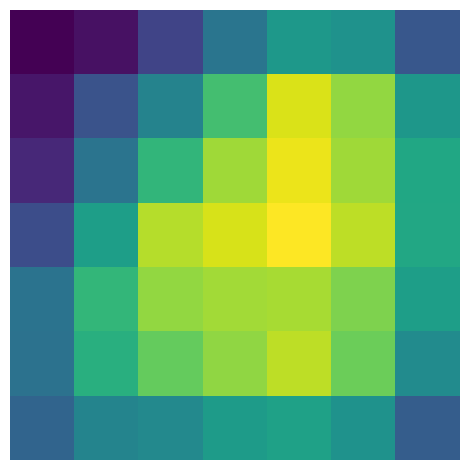

In [21]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy())
plt.axis('off')
plt.tight_layout()
plt.show()

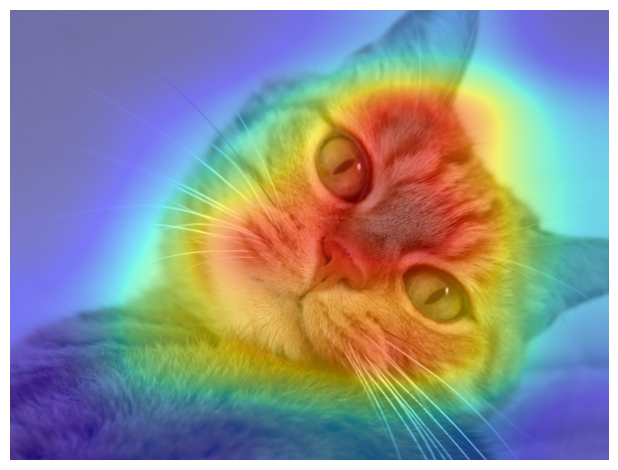

In [22]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

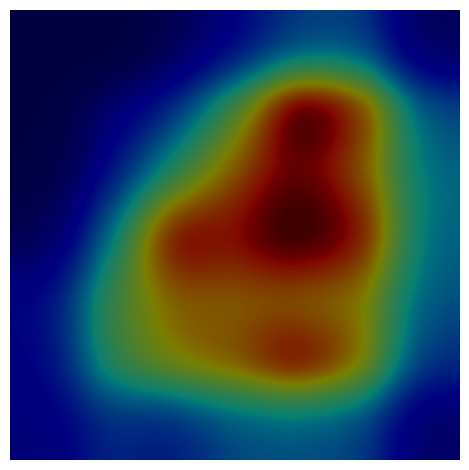

In [23]:
# Resize the CAM and overlay it
black_img = torch.zeros((3, 224, 224))
result = overlay_mask(to_pil_image(black_img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

Finally, the top-9 CAMs are shown below overlayed on the input image.

In [33]:
# activation_map[0].squeeze(0).size()

torch.Size([7, 7])

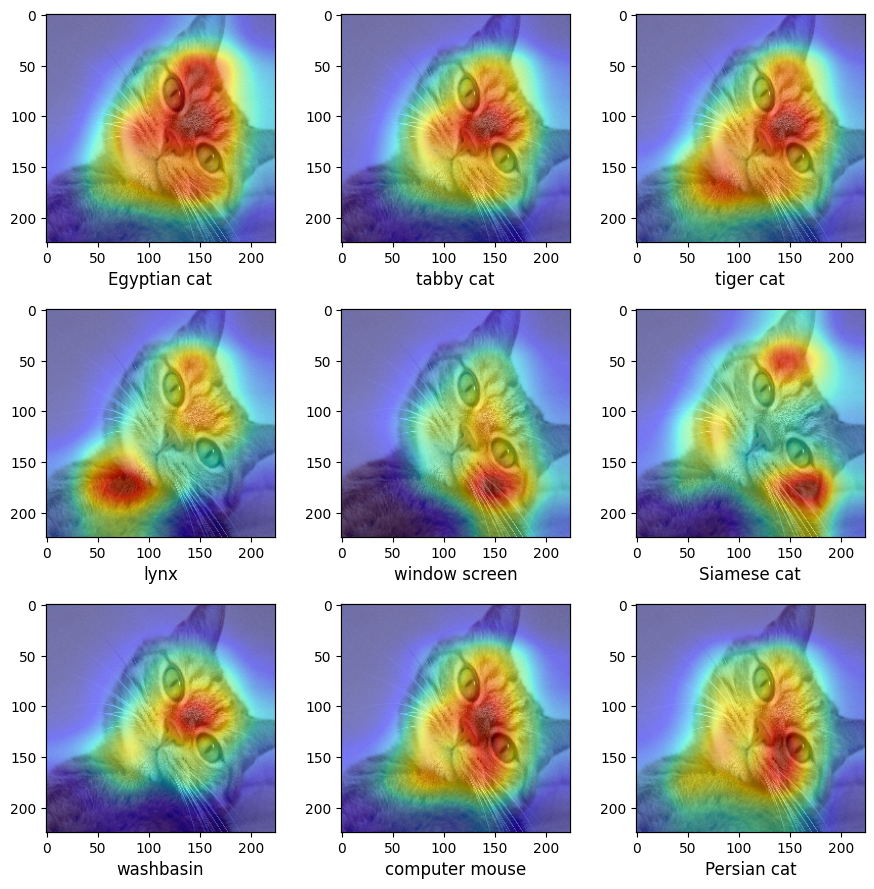

In [24]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

top_9_idxs = torch.argsort(out.squeeze(0), descending=True)[:9]
resized_img = resize(img, (224, 224))

rows = 3
columns = 3

labels = ['Egyptian cat', 'tabby cat', 'tiger cat', 'lynx', 'window screen', 'Siamese cat', 'washbasin', 'computer mouse', 'Persian cat']

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    
    idx = top_9_idxs[num - 1].item()
    
    activation_map = cam_extractor(idx, out)
    result = overlay_mask(to_pil_image(resized_img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

    plt.imshow(result, aspect='auto')
    plt.xlabel(f'{labels[num-1]}', fontsize=12)    
    
fig.tight_layout() # used to adjust padding between subplots 

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

# save plot
fig.savefig('CAM_overlay.png')

Now, in order to visualize the last conv layer feature maps, we extract the `layer4` output.

In [25]:
for name, module in model.named_children(): # Printing the model layer names
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


We create a temporary Sequential module, leaving out only the last 2 layers (`avgpool` and `fc`). This allows us to extract the last conv layer feature maps, which we will use for visualization.

In [26]:
f = torch.nn.Sequential(*list(model.children())[:-2])  
features = f(input_tensor.unsqueeze(0))

In [27]:
# features.squeeze(0)[3].detach().numpy()

array([[0.        , 0.        , 1.0843891 , 1.3900405 , 1.832587  ,
        1.4184685 , 0.95383143],
       [0.5030913 , 1.884671  , 3.366516  , 3.2550352 , 2.821244  ,
        1.7123011 , 1.016191  ],
       [1.3681142 , 3.1500032 , 3.9192266 , 3.6539364 , 2.8570557 ,
        1.7515205 , 0.9499884 ],
       [1.7255727 , 3.4301918 , 4.4895873 , 5.298408  , 4.158081  ,
        2.133666  , 0.7625136 ],
       [1.2548127 , 2.0153005 , 2.6720517 , 4.3040195 , 4.0817046 ,
        2.7184525 , 1.5227872 ],
       [0.        , 0.        , 1.2390242 , 3.087069  , 4.2000203 ,
        3.4915872 , 2.268451  ],
       [0.        , 0.        , 0.5054377 , 2.1102762 , 3.7669222 ,
        3.909195  , 2.561243  ]], dtype=float32)

Now, we visualize the top-9 feature maps corresponding to the most suited ImageNet class label `Egyptian cat`.

In [28]:
for name, parameter in model.named_parameters():
  if name == 'fc.weight':
    fc_weights = parameter

In [29]:
top_idx = top_9_idxs[0].item()
top_cls_wts = fc_weights[top_idx]
top_9_wts_idxs = torch.argsort(top_cls_wts, descending=True)[:9]

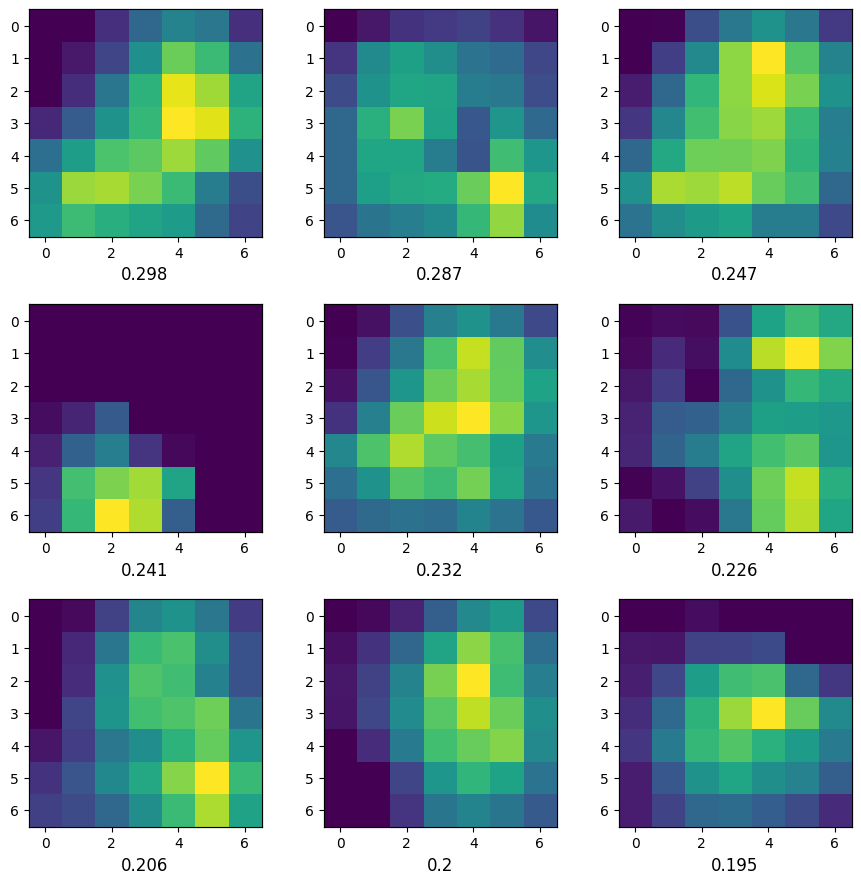

In [30]:
rows = 3
columns = 3

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    idx = top_9_wts_idxs[num - 1].item()
    
    feature = features.squeeze(0)[idx]
    plt.imshow(feature.detach().numpy(), aspect='auto')
    plt.xlabel(f'{round(top_cls_wts[idx].item(), 3)}', fontsize=12)    
    
fig.tight_layout() # used to adjust padding between subplots 

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

# save plot
fig.savefig('Top-9 Feature Maps for Egyptian Cat.png')

In [31]:
# feature.size()

torch.Size([7, 7])

We overlay these feature maps on the input image  for visualization. 

<br/>Some observations : 

*   The top-9 feature maps loosely fit the area around the cat's face.

*   The corresponding weights also show gradual variation instead of drastic differences.

<br/>This means that the final CAM **distributes its weightage evenly among multiple feature maps** instead of giving high weightage to only a few maps.

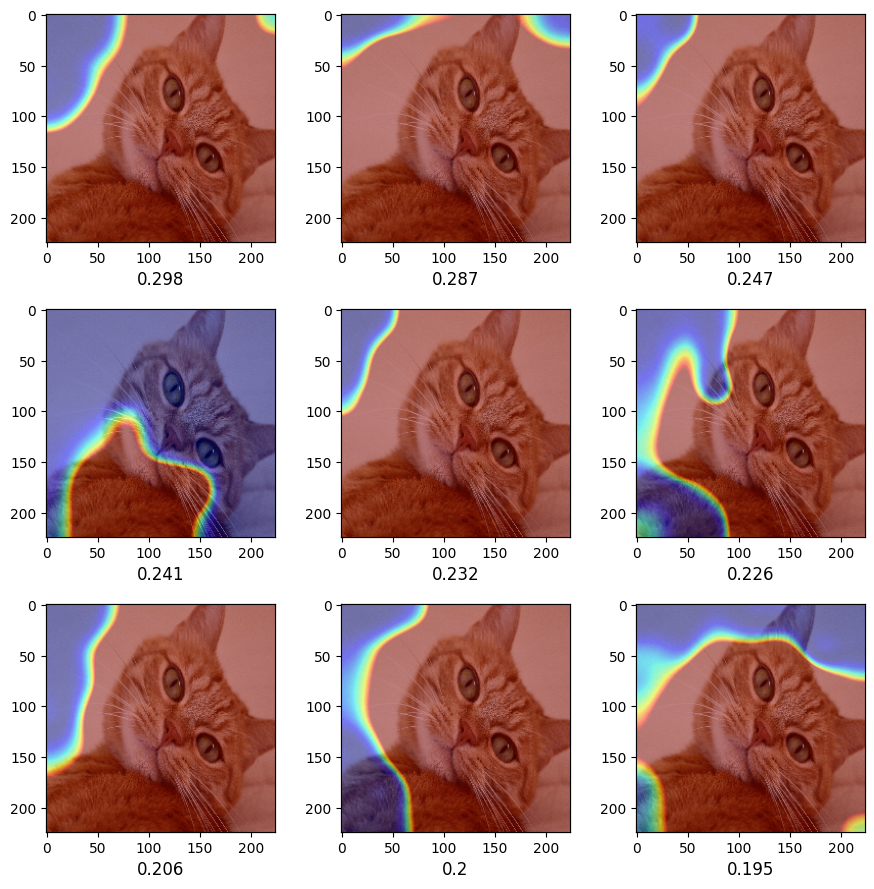

In [54]:
rows = 3
columns = 3

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    idx = top_9_wts_idxs[num - 1].item()
    
    feature = features.squeeze(0)[idx]
    result = overlay_mask(to_pil_image(resized_img), to_pil_image(feature.detach().numpy(), mode='F'), alpha=0.5)
    plt.imshow(result, aspect='auto')
    plt.xlabel(f'{round(top_cls_wts[idx].item(), 3)}', fontsize=12)    
    
fig.tight_layout() # used to adjust padding between subplots 

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

# save plot
fig.savefig('Top-9 Overlayed Feature Maps for Egyptian Cat with labels as weights.png')

For completeness, we also overlay the features maps corresponding to the lowest weightage given by the `Egyptian Cat` CAM.

<br/>Evidently, these feature maps don't focus on the key features of the cat's face - and hence weren't given weightage while searching for the cat features.

In [39]:
top_idx = top_9_idxs[0].item()
top_cls_wts = fc_weights[top_idx]
last_9_wts_idxs = torch.argsort(top_cls_wts, descending=False)[:9]

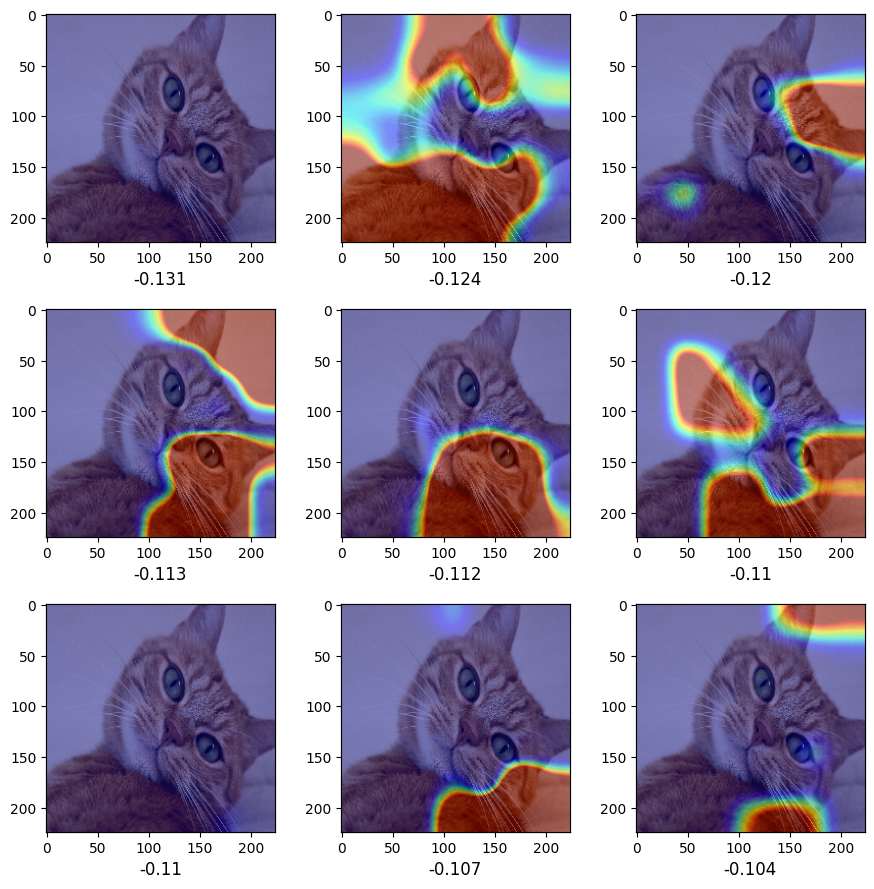

In [40]:
rows = 3
columns = 3

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    idx = last_9_wts_idxs[num - 1].item()
    
    feature = features.squeeze(0)[idx]
    result = overlay_mask(to_pil_image(resized_img), to_pil_image(feature.detach().numpy(), mode='F'), alpha=0.5)
    plt.imshow(result, aspect='auto')
    plt.xlabel(f'{round(top_cls_wts[idx].item(), 3)}', fontsize=12)    
    
fig.tight_layout() # used to adjust padding between subplots 

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

# save plot
fig.savefig('Last-9 Overlayed Feature Maps for Egyptian Cat with labels as weights.png')

**This part doesn't work because apparently CAM involves a sequence of steps from weighted combination, ReLU and finally normalization using (x-min)/(max-min).**

For implementation details, see [this](https://github.com/frgfm/torch-cam/blob/main/torchcam/methods/core.py).

In [53]:
approx_cam = torch.zeros((7, 7))
for i in range(1):
  idx = top_9_wts_idxs[i].item()
  feature = features.squeeze(0)[idx]
  print(top_cls_wts[idx])
  print(feature)
  print(top_cls_wts[idx]*feature)
  approx_cam += top_cls_wts[idx]*feature

# print(approx_cam)

tensor(0.2984, grad_fn=<SelectBackward0>)
tensor([[0.0000, 0.0000, 1.0303, 2.5833, 3.4412, 3.0656, 1.0624],
        [0.0000, 0.5404, 1.6205, 3.8686, 5.9608, 5.2619, 2.8900],
        [0.0000, 0.9948, 3.0143, 4.9867, 7.4203, 6.6017, 4.5108],
        [0.8861, 2.2441, 3.9251, 5.1458, 7.7069, 7.3529, 4.9848],
        [2.8148, 4.3338, 5.5377, 5.7756, 6.5866, 5.8354, 3.8996],
        [3.9321, 6.5513, 6.6944, 6.1421, 5.2606, 3.2628, 1.8400],
        [4.1510, 5.2959, 4.8320, 4.4994, 4.2257, 2.6616, 1.5706]],
       grad_fn=<SelectBackward0>)
tensor([[0.0000, 0.0000, 0.3074, 0.7708, 1.0268, 0.9147, 0.3170],
        [0.0000, 0.1613, 0.4835, 1.1544, 1.7787, 1.5701, 0.8623],
        [0.0000, 0.2968, 0.8995, 1.4880, 2.2142, 1.9699, 1.3460],
        [0.2644, 0.6696, 1.1712, 1.5355, 2.2997, 2.1940, 1.4874],
        [0.8399, 1.2932, 1.6524, 1.7234, 1.9654, 1.7412, 1.1636],
        [1.1733, 1.9549, 1.9975, 1.8327, 1.5697, 0.9736, 0.5490],
        [1.2386, 1.5803, 1.4418, 1.3426, 1.2609, 0.7942, 0.4686]]

In [50]:
activation_map[0]

tensor([[[0.0000, 0.0525, 0.1369, 0.1491, 0.2165, 0.1424, 0.0138],
         [0.0765, 0.2740, 0.5185, 0.6084, 0.7079, 0.5077, 0.2766],
         [0.2031, 0.4362, 0.7424, 0.7298, 0.8544, 0.6837, 0.4159],
         [0.2786, 0.5078, 0.7964, 0.8247, 0.9120, 0.7202, 0.4451],
         [0.4304, 0.6452, 0.8598, 0.7878, 1.0000, 0.7232, 0.4779],
         [0.5245, 0.7622, 0.7654, 0.8398, 0.9154, 0.6604, 0.2927],
         [0.4606, 0.5900, 0.5890, 0.6327, 0.6591, 0.4980, 0.2142]]])

In [45]:
approx_cam.mean()

tensor(7.6182, grad_fn=<MeanBackward0>)

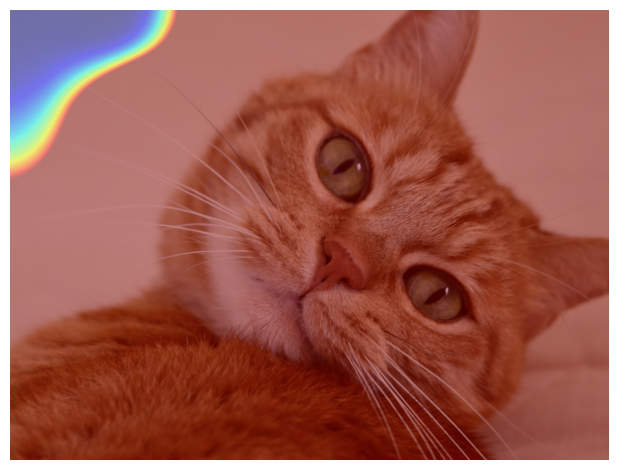

In [46]:
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image((approx_cam).detach().numpy(), mode='F'), alpha=0.5)

# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()